# Naives Bayes Classifier


## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scattertext as st
import spacy

from sklearn import model_selection, naive_bayes, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report

In [2]:
# stopwords from spaCy
nlp = spacy.load('en_core_web_sm')

## Data Preparation

In [3]:
stop_words = nlp.Defaults.stop_words

def preprocess(string):
    """
    Preprocess the input string. 

    Pre-process steps:
        1) Remove non-alphabetic characters and spaces
        2) Convert the string to lowercase
        3) Remove stopwords from the given string.
    
    Example:
        string = "   Hey,     how's it    going?    "
        output = "hey hows going"
    
    Args:
        string (str): Input string to preprocess.
    
    Returns:
        words (list): List of strings containing words in the input string.
    """
    # remove all characters apart from alphabets and spaces
    string = ''.join(c for c in string if (c.isalpha() or c.isspace()))
    # remove unnecessary whitespaces
    string = ' '.join(string.split())
    # convert all characters to lowercase
    string = string.lower()
    # remove stopwords from the string
    string = ' '.join([word for word in string.split() if word not in stop_words])

    return string

In [4]:
preprocess("   Hey,     how's it    going?    ")

'hey hows going'

In [5]:
def get_category(string):
    """
    Extract the primary category from the string.
    The primary category is the first category in the column "product_category_tree", and is followed by ' >>'.
    Further, some products don't seem to have a primary category and have the product stated as the caegory itself.
    We can drop such categories as they are not associated with more than 10 products each.
    
    Example:
        string = '["Furniture >> Living Room Furniture >> Sofa Beds & Futons >> FabHomeDecor Fabric Double Sofa Bed (Finish Colo..."]'
        output = 'Furniture'
    
    Args:
        string (str): Input string to extract primary category.
    
    Returns:
        words (list): Primary category for the product.
    """
    if '>>' in string:
        string = string.split(' >> ')
        category = string[0][2:]
    else:
        category = 'None'
    return category

In [6]:
print("Valid category: ", 
      get_category('["Furniture >> Living Room Furniture >> Sofa Beds & Futons >> FabHomeDecor Fabric Double Sofa Bed (Finish Colo..."]'))

print("Invalid category: ", get_category('Furniture'))

Valid category:  Furniture
Invalid category:  None


In [7]:
# load the dataset
flipkart_df = pd.read_csv('dataset.csv')
flipkart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  20000 non-null  object 
 1   crawl_timestamp          20000 non-null  object 
 2   product_url              20000 non-null  object 
 3   product_name             20000 non-null  object 
 4   product_category_tree    20000 non-null  object 
 5   pid                      20000 non-null  object 
 6   retail_price             19922 non-null  float64
 7   discounted_price         19922 non-null  float64
 8   image                    19997 non-null  object 
 9   is_FK_Advantage_product  20000 non-null  bool   
 10  description              19998 non-null  object 
 11  product_rating           20000 non-null  object 
 12  overall_rating           20000 non-null  object 
 13  brand                    14136 non-null  object 
 14  product_specifications

In [8]:
# the following columns do not contribute to the task, so we can drop them safely
# Columns: crawl_timestamp, product_url, pid, retail_price, discounted_price,
# image, is_FK_Advantage_product, product_rating, overall_rating, product_specifications
flipkart_df = flipkart_df[['uniq_id', 'product_name', 'product_category_tree', 'description']]

# since description is the miain feature, we remove the rows for which the description is missing
flipkart_df = flipkart_df[~flipkart_df['description'].isnull()]
flipkart_df.head(5)

,uniq_id,product_name,product_category_tree,description
0,c2d766ca982eca8304150849735ffef9,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",Key Features of Alisha Solid Women's Cycling S...
1,7f7036a6d550aaa89d34c77bd39a5e48,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",FabHomeDecor Fabric Double Sofa Bed (Finish Co...
2,f449ec65dcbc041b6ae5e6a32717d01b,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",Key Features of AW Bellies Sandals Wedges Heel...
3,0973b37acd0c664e3de26e97e5571454,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",Key Features of Alisha Solid Women's Cycling S...
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",Specifications of Sicons All Purpose Arnica Do...


In [9]:
# get primary categories
flipkart_df['product_category_tree'] = flipkart_df['product_category_tree'].apply(get_category)

# rename product_category_tree to primay_category
flipkart_df.rename(columns={'product_category_tree': 'primary_category'}, inplace=True)
flipkart_df.head(5)

,uniq_id,product_name,primary_category,description
0,c2d766ca982eca8304150849735ffef9,Alisha Solid Women's Cycling Shorts,Clothing,Key Features of Alisha Solid Women's Cycling S...
1,7f7036a6d550aaa89d34c77bd39a5e48,FabHomeDecor Fabric Double Sofa Bed,Furniture,FabHomeDecor Fabric Double Sofa Bed (Finish Co...
2,f449ec65dcbc041b6ae5e6a32717d01b,AW Bellies,Footwear,Key Features of AW Bellies Sandals Wedges Heel...
3,0973b37acd0c664e3de26e97e5571454,Alisha Solid Women's Cycling Shorts,Clothing,Key Features of Alisha Solid Women's Cycling S...
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,Sicons All Purpose Arnica Dog Shampoo,Pet Supplies,Specifications of Sicons All Purpose Arnica Do...


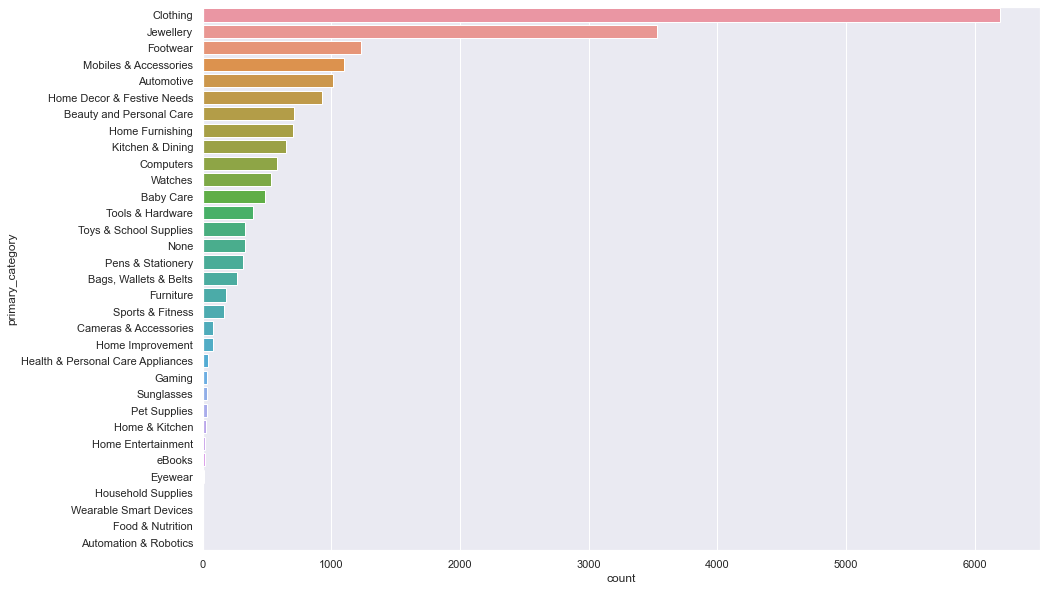

In [10]:
# visualise the split of categories
plt.figure(figsize=(15,10))
sns.set_theme(style='darkgrid')
ax = sns.countplot(y='primary_category', data=flipkart_df, order=flipkart_df['primary_category'].value_counts().index)

In [11]:
# drop rows with unknown primary category, i.e., primary_category = 'None'
flipkart_df = flipkart_df[flipkart_df['primary_category'] != 'None']
flipkart_df.groupby(['primary_category']).count().sort_values(by='uniq_id', ascending=False)

# get a list of only top 15 categories (by count of products)
# tbe remaining categories contribute less than 1% products each, so we can drop them for the meanwhile
categories = list(flipkart_df.groupby('primary_category').count().sort_values(by='uniq_id',ascending=False).head(15).index)
print("Primary categories: ", categories)

Primary categories:  ['Clothing', 'Jewellery', 'Footwear', 'Mobiles & Accessories', 'Automotive', 'Home Decor & Festive Needs', 'Beauty and Personal Care', 'Home Furnishing', 'Kitchen & Dining', 'Computers', 'Watches', 'Baby Care', 'Tools & Hardware', 'Toys & School Supplies', 'Pens & Stationery']


In [12]:
# retain only the required categories
flipkart_df = flipkart_df[flipkart_df['primary_category'].isin(categories)]

# apply preprocess() to description
flipkart_df['description'] = flipkart_df['description'].astype('str').apply(preprocess)
flipkart_df.info()

# create a new dataframe containing only the rows that have a desription
df = flipkart_df[~flipkart_df['description'].isnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18676 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   uniq_id           18676 non-null  object
 1   product_name      18676 non-null  object
 2   primary_category  18676 non-null  object
 3   description       18676 non-null  object
dtypes: object(4)
memory usage: 729.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18676 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   uniq_id           18676 non-null  object
 1   product_name      18676 non-null  object
 2   primary_category  18676 non-null  object
 3   description       18676 non-null  object
dtypes: object(4)
memory usage: 729.5+ KB


In [13]:
# save the preprocessed dataframe with columns (primary_category, description) for future use
save_df = flipkart_df[['primary_category', 'description']]
save_df.to_csv('preprocessed.csv', index=False)

In [14]:
# use scattertext and spaCy to output the words used by different categories

# create a scattertext Corpus from the dateframe
corpus = st.CorpusFromPandas(df, category_col='primary_category', text_col='description', nlp=nlp).build()

# the following words differentiate the descriptions of products from a general English corpus
print(list(corpus.get_scaled_f_scores_vs_background().index[:10]))

['flipkartcom', 'apparels', 'ipad', 'tshirt', 'multicolor', 'showpiece', 'branded', 'kurti', 'voylla', 'leggings']


In [15]:
# find the terms that are most associated with product descriptions of different primary categories
term_freq_df = corpus.get_term_freq_df()

# for each category, print the most popular terms in the product descriptions
# this gives us an idea about how the different categories will be distinguised
for category in categories:
    score = category + ' Score'
    term_freq_df[score] = corpus.get_scaled_f_scores(category)
    print(f"Most popular terms for category {category}: ", list(term_freq_df.sort_values(by=score, ascending=False).index[:10]))

Most popular terms for category Clothing:  ['mens polo', 'printed womens', 'printed mens', 'bra', 'womens coverage', 'tshirt rs', 'tshirt buy', 'solid mens', 'coverage bra', 'womens solid']
Most popular terms for category Jewellery:  ['k ring', 'ring rs', 'diamond k', 'alloy necklace', 'necklace rs', 'bangle set', 'necklace buy', 'karatcraft', 'ring buy', 'gold diamond']
Most popular terms for category Footwear:  ['wedges flipkartcom', 'women flats', 'sandal details', 'shoes buy', 'general occasion', 'women heels', 'loafers buy', 'pack weight', 'bellies', 'g single']
Most popular terms for category Mobiles & Accessories:  ['ipad sleeves', 'world currently', 'love world', 'covers sizes', 'mobile covers', 'robust mobile', 'sourced artists', 'painstakingly sourced', 'art painstakingly', 'licensed art']
Most popular terms for category Automotive:  ['tata', 'speedwav', 'mahindra', 'sunshade', 'rear view', 'view mirror', 'car mat', 'buy allure', 'allure auto', 'car tray']
Most popular terms 

312.1575819233241


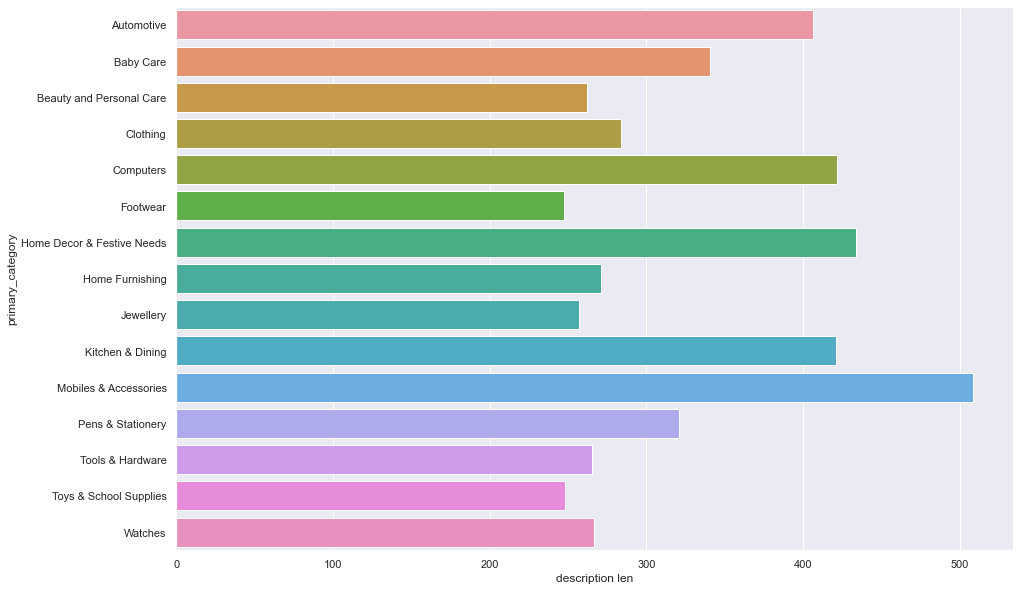

In [16]:
# find the average length of descriptions
df['description len'] = df['description'].str.len()
print(np.mean(df['description len']))

# create a new dataframe that stores the average length of descriptions grouped by category
dfg = df.groupby('primary_category')['description len'].mean().reset_index()

# plot average length of descriptions category-wise
plt.figure(figsize=(15,10))
sns.set_theme(style='darkgrid')
ax = sns.barplot(x='description len', y=dfg['primary_category'], data=dfg)

## Feature Engineering
1) CountVetorizer <br>
2) TF-IDF

In [17]:
# split the dataset into training and validation datasets 
train_x, test_x, train_y, test_y = model_selection.train_test_split(flipkart_df['description'], flipkart_df['primary_category'])

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.fit_transform(test_y)

### Count Vector



In [18]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')

### TF-IDF Vectors

In [19]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}')

## Naives Bayes Classifer

In [23]:
def NBClassifier(train_x, test_x, train_y, test_y, vect):
    """
    Train and evaluate a Naive Bayes classifier on the data.

    Args:
        vect: Vectorizer used to fit and transform data (Count or TF-IDF)
    """
    # define NB model
    classifier = naive_bayes.MultinomialNB()

    # convert the training data
    vect_train_x = vect.fit_transform(train_x)
    
    # fit the data to the NB model
    classifier.fit(vect_train_x, train_y)

    # print the score of the model
    print(f"Accuracy achieved on train set: ", classifier.score(vect_train_x, train_y) * 100, "%")

    # convert the test data
    vect_test_x = vect.transform(test_x)

    # print the score of the model
    print(f"Accuracy achieved on test set: ", classifier.score(vect_test_x, test_y) * 100, "%")

    # predict the labesl for test data
    predict_y = classifier.predict(vect_test_x)

    # print classification report
    print("\nClassification report: ")
    print(classification_report(test_y, predict_y))

In [24]:
NBClassifier(train_x, test_x, train_y, test_y, tfidf_vect)

Accuracy achieved on train set:  91.51852645106018 %
Accuracy achieved on test set:  89.78367958877705 %

Classification report: 
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       257
           1       1.00      0.42      0.59       118
           2       1.00      0.65      0.79       172
           3       0.90      1.00      0.95      1506
           4       1.00      0.65      0.79       160
           5       1.00      0.93      0.96       291
           6       0.93      0.92      0.93       235
           7       0.92      0.83      0.87       179
           8       0.80      1.00      0.89       919
           9       0.98      0.75      0.85       156
          10       0.91      0.95      0.93       288
          11       1.00      0.20      0.33        76
          12       1.00      0.81      0.89       108
          13       1.00      0.09      0.17        76
          14       1.00      0.97      0.98       128

    

In [25]:
NBClassifier(train_x, test_x, train_y, test_y, count_vect)

Accuracy achieved on train set:  96.63739558792032 %
Accuracy achieved on test set:  95.1167273506104 %

Classification report: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       257
           1       0.93      0.57      0.71       118
           2       0.91      0.98      0.95       172
           3       0.98      1.00      0.99      1506
           4       0.91      0.78      0.84       160
           5       0.98      0.98      0.98       291
           6       0.90      0.99      0.94       235
           7       0.91      0.99      0.95       179
           8       0.94      1.00      0.97       919
           9       0.98      0.83      0.90       156
          10       0.96      0.92      0.94       288
          11       0.95      0.47      0.63        76
          12       0.96      0.94      0.95       108
          13       0.72      0.74      0.73        76
          14       0.99      0.99      0.99       128

    a

### Result
Using traditional ML algorithms, I found out that the Naive Bayes algorithm performs very well on the given dataset for product classifcaiton.

Among the two variants considered, the one with the Count Vectorizer performs better than the TF-IDF Vectorizer.